In [1]:
import cv2
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
from ipywidgets import interact, Layout
import cvzone
import time
import threading
import multiprocessing as mp
from multiprocessing.shared_memory import SharedMemory
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import t2
import pickle, dill
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
with open('model_0.pkl', 'rb') as file:  
    clf = pickle.load(file)

In [4]:
font = cv2.FONT_HERSHEY_SIMPLEX
width_img = 1280
height_img = 960

a = df['HSV'][df['ID'] == 1].iloc[0][1]
hue = widgets.IntRangeSlider(min=0, max=258, step=1, value=[a[0], a[1]], layout=Layout(width='80%'), description='Hue')
sat = widgets.IntRangeSlider(min=0, max=255, step=1, value=[a[2], a[3]], layout=Layout(width='80%'), description='Saturation')
val = widgets.IntRangeSlider(min=0, max=255, step=1, value=[a[4], a[5]], layout=Layout(width='80%'), description='Value')

x1 = widgets.IntSlider(min=0, max=width_img, step=1, value=100, layout=Layout(width='80%'), description='x1')
y1 = widgets.IntSlider(min=0, max=height_img, step=1, value=100, layout=Layout(width='80%'), description='y1')
w = widgets.IntSlider(min=0, max=width_img, step=1, value=300, layout=Layout(width='80%'), description='w')
h = widgets.IntSlider(min=0, max=height_img, step=1, value=300, layout=Layout(width='80%'), description='h')

In [5]:
cap = cv2.VideoCapture(0)
display_handle=display(None, display_id=True)

tmp = mp.Value('i', 0)
contours_size = mp.Value('i', 0)
len_contours = mp.Value('i', 0)

frame_memory = SharedMemory(name='FrameMemory', create=True, size=width_img*height_img*3)
contours_memory = SharedMemory(name='ContoursMemory', create=True, size=4096)

p1 = mp.Process(target=t2.my_process, args=(tmp, width_img, height_img, len_contours, contours_size,), daemon=True)
p1.start()

stopButton = widgets.ToggleButton(description='Stop', disabled=False)

def preprocess(fr):
    mask = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
    mask = cv2.GaussianBlur(mask, (5,5), 2)
    mask = cv2.Canny(mask, 30, 255, apertureSize=5)
    return mask

def contours(fr_m, fr):
    biggest = np.array([])
    max_area = 0
    contours, hierarchy = cv2.findContours(fr_m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > 100_000:
            epsilon = 0.1 * cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, epsilon, True)
            cv2.drawContours(fr, cnt, -1, (0,255,0), 5)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest

def reorder(my_points):
    my_points = my_points.reshape((4,2))
    my_points_new = np.zeros((4,1,2), np.int32)
    add = my_points.sum(1)

    my_points_new[0] = my_points[np.argmin(add)]
    my_points_new[3] = my_points[np.argmax(add)]

    diff = np.diff(my_points, axis=1)

    my_points_new[1] = my_points[np.argmin(diff)]
    my_points_new[2] = my_points[np.argmax(diff)]

    return my_points_new

def get_warp(img, approx):
    biggest = reorder(approx)

    pts1 = np.float32(biggest)
    pts2 = np.float32([[0, 0], [width_img, 0], [0, height_img], [width_img, height_img]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    img_output = cv2.warpPerspective(img, matrix, (width_img, height_img))
    img_cropped = cv2.resize(img_output, (width_img, height_img))
    image_grayworld = (img_cropped * (img_cropped.mean() / img_cropped.mean(axis=(0, 1)))).astype(np.uint8)
    return image_grayworld

# CONTOURS TRAIN
# def text_detection(img, contours_data):
#     tensor = np.empty((1,4))
#     for contour in contours_data[:,:]:
#         x, y, w, h = contour[0], contour[2], contour[1], contour[3]
#         cv2.rectangle(img, (x, y), (w, h), (255, 255, 0), 6)
#         tensor = np.append(tensor, [[x, y, w, h]], axis=0)
#     if len_contours.value > 1:
#         if len(l2) < 2010:   
#             l2.append((tensor[1:,:].astype(int), 'Karta Polaka (BACK)'))
#         else:
#             print(len(l2))

# CONTOURS CHECK
def text_detection(fr, img, contours_data):
    if len_contours.value == 0:
        st = 'detecting...'
        color = (0, 0, 255)
        ind = -1
    else:
        color = (0, 255, 0)
        temp = np.empty((1,4))
        for contour in contours_data[:,:]:
            x, y, w, h = contour[0], contour[2], contour[1], contour[3]
            # cv2.rectangle(img, (x, y), (w, h), (255, 255, 0), 6)
            if temp.shape[0] < 50: # 50 pr2[2]
                temp = np.append(temp, [[x, y, w, h]], axis=0)
                
        t = temp[1:,:].astype(int)
        t = np.pad(t, [(0, 50 - t.shape[0]),(0, 0)], mode='constant').T.reshape(1, -1) # 50 pr2[2]
        ind = clf.predict(t).argmax(1)[0]
        st = df['Name'][df['ID'] == ind].iloc[0]
    cv2.putText(fr, st, (7, 70), font, 3, color, 7, cv2.LINE_AA)
    return ind

def filters_online(fr, hue, sat, val):
    lower = np.array([hue.value[0], sat.value[0], val.value[0]])
    upper = np.array([hue.value[1], sat.value[1], val.value[1]])
    mask = cv2.cvtColor(fr, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(mask, lower, upper)
    return mask

def filters_predict(fr, ind, df):
    l = df['HSV'][df['ID'] == ind].iloc[0]
    lower = np.array([179, 0, 0])
    upper = np.array([179, 0, 0])
    mask = cv2.inRange(fr, lower, upper)

    for i in l:
        lower = np.array([i[0], i[2], i[4]])
        upper = np.array([i[1], i[3], i[5]])
        m = cv2.cvtColor(fr, cv2.COLOR_RGB2HSV)
        m = cv2.inRange(m, lower, upper)
        mask = cv2.addWeighted(mask,1,m,1,0)
    return mask

def watmark_online(img, x1, y1, w, h):
    cv2.rectangle(img, (x1.value, y1.value), (x1.value+w.value, y1.value+h.value), (255, 0, 0), 10)

def watermark_rect(img, ind, df):
    l = df['Watermark_contour'][df['ID'] == ind].iloc[0]
    for i in l:
        cv2.rectangle(img, (i[0], i[1]), (i[0]+i[2], i[1]+i[3]), (255, 0, 0), 10)

# WATERMARKS TRAIN
# def watermark_train(img, ind, df):
#     if len(n) < 2000:
#         if ind != -1:
#             l = df['Watermark_contour'][df['ID'] == ind].iloc[0]
#             for j, i in enumerate(l):
#                 crop_img = img[i[1]:i[1]+i[3], i[0]:i[0]+i[2]]
#                 resized = cv2.resize(crop_img, (256, 256), interpolation = cv2.INTER_AREA)
#                 n.append((resized, df['ID'][df['ID'] == ind].iloc[0] * 10 + j))
#     else:
#         close()
#         display_handle.update(None)

# WATERMARKS CHECK
def watermark_check(img, ind, df):
    if ind != -1:
        l = df['Watermark_contour'][df['ID'] == ind].iloc[0]
        for j, i in enumerate(l):
            crop_img = img[i[1]:i[1]+i[3], i[0]:i[0]+i[2]]
            resized = cv2.resize(crop_img, (128,128), interpolation = cv2.INTER_AREA)
            x = np.reshape(resized, (1,1,128,128))
            x = torch.tensor(x / 255).float()
            prediction = model(x)
            print(torch.softmax(prediction, dim=1))

def close():
    frame_memory.close()
    frame_memory.unlink()
    contours_memory.close()
    contours_memory.unlink()
    p1.terminate()
    cap.release()

def view(button, hue, sat, val, x1, y1, w, h,):
    frame_data = np.ndarray((height_img,width_img,3), dtype=np.uint8, buffer=frame_memory.buf)
    contours_data = np.ndarray((1,4), dtype=np.int32, buffer=contours_memory.buf)
    
    while True:
        _, frame = cap.read()

        frame_masked = preprocess(frame)
        frame_contours = contours(frame_masked, frame)
        
        if frame_contours.size != 0:
            img_warped = get_warp(frame, frame_contours)
            contours_size.value = 1
            
            if tmp.value == 1:
                frame_data[:,:,:] = img_warped[:,:,:]
                contours_data = np.ndarray((len_contours.value,4), dtype=np.int32, buffer=contours_memory.buf)
                tmp.value = 0

            frame_detect = text_detection(frame, img_warped, contours_data)
            # filt_online = filters_online(img_warped, hue, sat, val)
            filt_predict = filters_predict(img_warped, frame_detect, df)
            # watmark_online(filt_online, x1, y1, w, h)
            watermark_rect(filt_predict, frame_detect, df)
            # watermark_check(filt_predict, frame_detect, df)
            # watermark_train(filt_predict, frame_detect, df)
        
        else:
            img_warped = frame.copy()
            # filt_online = frame.copy()
            filt_predict = frame.copy()
    
            len_contours.value = 0
            frame_data[:,:,:] = img_warped[0,0,0]

        img_stack = cvzone.stackImages([
            frame,
            # img_warped,
            # filt_online,
            filt_predict,
        ], 2, 1)

        _, frame = cv2.imencode('.jpeg', img_stack) 
        display_handle.update(Image(data=frame.tobytes()))
        if stopButton.value==True:
            close()
            display_handle.update(None)

display(stopButton, hue, sat, val, x1, y1, w, h,)
thread = threading.Thread(target=view, args=(stopButton, hue, sat, val, x1, y1, w, h,))
thread.start()

None

ToggleButton(value=False, description='Stop')

IntRangeSlider(value=(0, 65), description='Hue', layout=Layout(width='80%'), max=258)

IntRangeSlider(value=(23, 255), description='Saturation', layout=Layout(width='80%'), max=255)

IntRangeSlider(value=(0, 255), description='Value', layout=Layout(width='80%'), max=255)

IntSlider(value=100, description='x1', layout=Layout(width='80%'), max=1280)

IntSlider(value=100, description='y1', layout=Layout(width='80%'), max=960)

IntSlider(value=300, description='w', layout=Layout(width='80%'), max=1280)

IntSlider(value=300, description='h', layout=Layout(width='80%'), max=960)

In [3]:
# df = pd.DataFrame({'Name': None, 'HSV': [[[179,179,0,0,0,0]]], 'ID': -1, 'Path': None, 'Watermark_contour': [[[0,0,0,0]]]}, index=[0])
df = pd.DataFrame({'Name': None, 'HSV': [[]], 'ID': -1, 'Path': None, 'Watermark_contour': [[[0,0,0,0]]]}, index=[0])

df.loc[len(df.index)] = ['Karta Polaka (FRONT)', [[0,179,160,255,0,255]], 0, None, [[5,5,220,295]]]
df.loc[len(df.index)] = ['Karta Polaka (BACK)', [[0,179,65,255,0,255], [0,65,23,255,0,255]], 1, None, [[320,5,670,500],[1085,30,180,220]]]
df.loc[len(df.index)] = ['Driver License (FRONT)', [[0,179,100,255,0,255]], 2, None, [[1050,20,210,170],[10,770,470,160]]]
df.loc[len(df.index)] = ['Driver License (BACK)', [], 3, None, []]
df.loc[len(df.index)] = ['Poland ID (2021)', [[0,255,175,255,95,235],[87,115,39,77,128,207]], 4, 'id/11.jpg',[]]
df.loc[len(df.index)] = ['Czech ID (2023)', [[0,10,140,255,90,255]], 5, 'id/12.jpg',[]]
df.loc[len(df.index)] = ['Austia ID (2021)', [[0,10,195,255,80,150]], 6,'id/13.jpg',[]]
df.loc[len(df.index)] = ['Germany ID (2022)', [[0,45,135,210,85,150],[70,90,50,255,100,255]], 7,'id/14.jpeg',[]]
df

,Name,HSV,ID,Path,Watermark_contour
0,None,[],-1,None,"[[0, 0, 0, 0]]"
1,Karta Polaka (FRONT),"[[0, 179, 160, 255, 0, 255]]",0,None,"[[5, 5, 220, 295]]"
2,Karta Polaka (BACK),"[[0, 179, 65, 255, 0, 255], [0, 65, 23, 255, 0...",1,None,"[[320, 5, 670, 500], [1085, 30, 180, 220]]"
3,Driver License (FRONT),"[[0, 179, 100, 255, 0, 255]]",2,None,"[[1050, 20, 210, 170], [10, 770, 470, 160]]"
4,Driver License (BACK),[],3,None,[]
5,Poland ID (2021),"[[0, 255, 175, 255, 95, 235], [87, 115, 39, 77...",4,id/11.jpg,[]
6,Czech ID (2023),"[[0, 10, 140, 255, 90, 255]]",5,id/12.jpg,[]
7,Austia ID (2021),"[[0, 10, 195, 255, 80, 150]]",6,id/13.jpg,[]
8,Germany ID (2022),"[[0, 45, 135, 210, 85, 150], [70, 90, 50, 255,...",7,id/14.jpeg,[]


In [58]:
p1.terminate()
frame_memory.close()
contours_memory.close()
frame_memory.unlink()
contours_memory.unlink()
cap.release()
time.sleep(0.1)
p1.is_alive()

False

In [6]:
print(thread.is_alive(), p1.is_alive())

False False


In [110]:
n = []

In [141]:
len(n)

2000

In [136]:
del n[1400:1600]

In [156]:
n[1900]

(array([[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]], dtype=uint8),
 20)

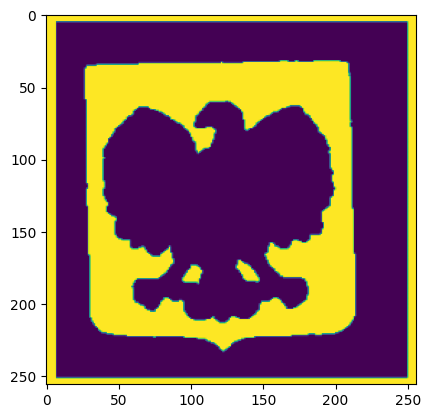

In [158]:
plt.imshow(n[101][0])

In [146]:
with open('n_watermarks.pkl', 'wb') as f:
    pickle.dump(n, f)

In [24]:
l2 = []

In [27]:
del l2[:10]

In [30]:
del l2[500:510]

In [33]:
del l2[1000:1010]

In [36]:
del l2[1500:1510]

In [37]:
len(l2)

2000

In [38]:
def data_prepare(itemlist, target_dict):
    s = 0
    len_dict = len(target_dict)
    
    for i in itemlist:
        if s < i[0].shape[0]:
            s = i[0].shape[0]
            
    ret_input = np.empty((1, s * 4))
    ret_target = np.empty((1, len_dict))
    eye = np.eye(len_dict)
            
    for i in itemlist:
        t = np.pad(i[0], [(0, s - i[0].shape[0]),(0, 0)], mode='constant')
        
        ret_input = np.vstack((ret_input, t.T.reshape(1, -1)))
        ret_target = np.vstack((ret_target , eye[target_dict[i[1]]]))
        
    return ret_input[1:,:], ret_target[1:,:], s

In [40]:
pr = data_prepare(l2, target_dict)

In [41]:
pr[2]

50

In [44]:
X_train, X_test, y_train, y_test = train_test_split(pr[0], pr[1], test_size=0.2)

In [45]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 200), (400, 200), (1600, 4), (400, 4))

In [46]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

ExtraTreesClassifier(random_state=0)

In [47]:
accuracy_score(y_train, clf.predict(X_train)), accuracy_score(y_test, clf.predict(X_test))

(1.0, 1.0)

In [50]:
with open('model_0.pkl', 'wb') as file:  
    pickle.dump(clf, file)

In [42]:
with open('n_watermarks.pkl', 'rb') as f:
    n = pickle.load(f)

In [45]:
df2 = pd.DataFrame({'a': [s[0] for s in n], 'b': [s[1] for s in n]})
ohe = OneHotEncoder()
a = ohe.fit_transform(df2[['b']]).toarray()
df2['ohe_class'] = a.tolist()
df3 = df2.drop('b', axis=1)

In [49]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(1, 16, kernel_size = 5, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, kernel_size = 5, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(28800,1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 5)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [50]:
model = MyModel()
model.load_state_dict(torch.load('model_watermarks.pth', map_location=torch.device('cpu')))
model.eval()

MyModel(
  (network): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=28800, out_features=1024, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.5, inplace=False)
    (11): Linear(in_features=1024, out_features=5, bias=True)
  )
)

In [60]:
x = df3['a'].iloc[0]
y = df3['ohe_class'].iloc[0]

x = cv2.resize(x, (128,128))
x = np.reshape(x, (1,1,128,128))
x = torch.tensor(x / 255).float()

y = np.reshape(y, (1,5))
y = torch.tensor(y).float()

prediction = model(x)
torch.softmax(prediction, dim=1)

tensor([[1.0000e+00, 8.2453e-14, 5.5440e-11, 7.8053e-14, 3.1114e-16]],
       grad_fn=<SoftmaxBackward0>)

In [53]:
df2

,a,b,ohe_class
0,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
1,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
2,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
4,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...
1995,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",21,"[0.0, 0.0, 0.0, 0.0, 1.0]"
1996,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",20,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1997,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",21,"[0.0, 0.0, 0.0, 0.0, 1.0]"
1998,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",20,"[0.0, 0.0, 0.0, 1.0, 0.0]"


In [24]:
b = ohe.fit(df[['b']])

In [32]:
c = {'ss': [[20]]}

In [34]:
b.transform(c['ss']).toarray()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


array([[0., 0., 0., 1., 0.]])